# BERT

## 1. Imports

In [ ]:
import numpy as np
import pandas as pd

import transformers
from transformers import BertModel, BertTokenizer, BertConfig

import torch
import torch.nn as nn
from torch import cuda
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from sklearn import metrics
from tqdm import tqdm
import ast
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('final_dataset_train.csv')
val_df = pd.read_csv('final_dataset_val.csv')
test_df = pd.read_csv('final_dataset_test.csv')
# train_df.groupby(['label']).size().plot.bar()
#set(val_df['author'].tolist()+train_df['author'].tolist())


## 2. Global Configurations

In [3]:
#https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb#scrollTo=7KnNeQx6SI78
#https://github.com/marcellusruben/medium-resources/blob/main/Text_Classification_BERT/bert_medium.ipynb
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 2 # 20
LEARNING_RATE = 2e-05
NUM_CLASSES = len(ast.literal_eval(train_df.loc[0, 'label']))
device = 'cuda' if cuda.is_available() else 'cpu'

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
device

'cuda'

## 3. Creating Dataset
we chop the book into several paragraphs each has 512 words, and convert words into word embeddings

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        
        get_y = lambda x: np.asarray(ast.literal_eval(x), dtype=int)        
        y = self.data['label'].apply(get_y)

        y1 = []
        for i in y:
            y1.append(i)
        y1 = np.argmax(np.asarray(y1), axis=1)
        self.targets = np.asarray(y1)
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        inputs = self.tokenizer(
            self.text[index],
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors="pt"
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': inputs['input_ids'].to(device, dtype=torch.long),
            'mask': inputs['attention_mask'].to(device, dtype=torch.long),
            'targets': torch.tensor(self.targets[index]).to(device, dtype=torch.long)
        }

In [5]:
training_set = CustomDataset(train_df.reset_index(drop=True), tokenizer, MAX_LEN)
val_set = CustomDataset(val_df.reset_index(drop=True), tokenizer, MAX_LEN)
test_set = CustomDataset(test_df.reset_index(drop=True), tokenizer, MAX_LEN)

train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **test_params)
test_loader = DataLoader(test_set, **test_params)

## 4. BERT Class
input -> Bert -> Pooling layer -> linear classifier

In [6]:
class BertForClassification(nn.Module):
    def __init__(self, config, pattern='default', layer=4):
        super(BertForClassification, self).__init__()
        self.bert = BertModel.from_pretrained(model_name, config=config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.pattern = pattern
        self.layer = layer
        if self.pattern == 'cat':
            self.classifier = nn.Linear(config.hidden_size * 4, NUM_CLASSES)
        else:
            self.classifier = nn.Linear(config.hidden_size, NUM_CLASSES)

        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pattern != 'default':
            encoded_layer = outputs.hidden_states
            outputs = []
            for l in encoded_layer[-self.layer:]:
                    outputs.append(l[:, 0].unsqueeze(1))
            outputs = torch.cat(outputs, dim=1)
            if self.pattern == 'max':
                outputs, _ = torch.max(outputs, dim=1)
            elif self.pattern == 'mean':
                outputs = torch.mean(outputs, dim=1)
            else:
                outputs = outputs.view(outputs.size(0), -1)
            pooled_output = self.dropout(outputs)
        else:
            pooled_output = self.dropout(outputs.pooler_output)
        linear = self.classifier(pooled_output)
        logits = self.relu(linear)
        return logits

An early strategy, if validation accuracy won't improve in 5 times, it ends epochs.

In [ ]:
#https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

We use cross entropy loss functon for multiple classification, and use ADAM to do gradient descent.

In [8]:
def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss().to(device)(outputs, targets)

In [9]:
def val(epoch, val_loader: DataLoader, model: BertModel):
    with torch.no_grad():
        model.eval()
        fin_targets = []
        fin_outputs = []
        for _, data in enumerate(tqdm(val_loader, 0)):
            outputs = model(input_ids=data['ids'].squeeze(1),
                            attention_mask=data['mask'])
            preds = torch.argmax(outputs, dim=1)
            fin_targets.extend(data['targets'].cpu().detach().numpy().tolist())
            fin_outputs.extend(preds.cpu().detach().numpy().tolist())
            loss = loss_fn(outputs, data['targets'])
        acc = (torch.tensor(fin_targets) == torch.tensor(fin_outputs)).float().mean().item()
        print(f"Epoch {epoch + 1}, Val accuracy = {acc}")
        # print(f'Val truth:{fin_targets}')
        # print(f'Val output:{fin_outputs}')
        val_df['truth'] = fin_targets
        val_df['pred'] = fin_outputs
        return loss

def train(epoch, training_loader: DataLoader, val_loader: DataLoader, model: BertModel):
    print(f'Model: {model.pattern}')
    num_train_optimization_steps = len(training_loader) * EPOCHS
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer,
        int(num_train_optimization_steps * 0.1),
        num_train_optimization_steps
    )
    
    early_stopper = EarlyStopper(patience=3)
    
    history = {'loss': [], 'acc': [], 'val': []}

    for epoch in range(epoch):
        fin_targets = []
        fin_outputs = []
        model.train()
        total_loss_train = 0
        for _, data in enumerate(tqdm(training_loader, 0)):
            outputs = model(input_ids=data['ids'].squeeze(1),
                            attention_mask=data['mask'])
            preds = torch.argmax(outputs, dim=1)
            fin_targets.extend(data['targets'].cpu().detach().numpy().tolist())
            fin_outputs.extend(preds.cpu().detach().numpy().tolist())
            loss = loss_fn(outputs, data['targets'])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            total_loss_train += loss.item()
        history['loss'].append(total_loss_train)

        acc = (torch.tensor(fin_targets) == torch.tensor(fin_outputs)).float().mean().item()
        history['acc'].append(acc)
        
        print(f"Epoch {epoch + 1}, Loss= {total_loss_train}, Train accuracy = {acc}")

        # Evaluate the model on the dev set
        validation_loss = val(epoch, val_loader, model)
        history['val'].append(validation_loss.cpu().detach().numpy().tolist())
        if early_stopper.early_stop(validation_loss):
            break
    return history

def test(test_loader, model: BertModel):
    # print(f'Model: {model.pattern}')
    # Use the fine-tuned model to make predictions on new data
    with torch.no_grad():
        model.eval()
        fin_targets = []
        proba_outputs = []
        fin_outputs = []
        for _, data in enumerate(tqdm(test_loader, 0)):
            outputs = model(input_ids=data['ids'].squeeze(1),
                            attention_mask=data['mask'])
            preds = torch.argmax(outputs, dim=1)
            fin_targets.extend(data['targets'].cpu().detach().numpy().tolist())
            proba_outputs.extend(outputs.cpu().detach().numpy().tolist())
            fin_outputs.extend(preds.cpu().detach().numpy().tolist())
#         acc = (torch.tensor(fin_targets) == torch.tensor(fin_outputs)).float().mean().item()
#         print(f"Test accuracy = {acc}")
        return (fin_targets, fin_outputs, proba_outputs)

Bert is a large model with 110 million parameters, to accelerate the training speed, we freeze weights in the embedding layer and top 8 encode layers. Only fine tune the last 4 layers and pooling layer.

In [10]:
def make_model(pattern):
    model = BertForClassification(BertConfig(output_hidden_states=True), pattern=pattern, layer=4)
    for param in model.bert.parameters():
        param.requires_grad = False
    for param in model.bert.encoder.layer[-4:].parameters():
        param.requires_grad = True
    for param in model.bert.pooler.parameters():
        param.requires_grad = True
    model.to(device)
    return model

## 5. Training and Testing

In [11]:
patterns = ['max', 'mean', 'cat', 'default']

In [12]:
models = [make_model(pattern) for pattern in patterns]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.trans

In [13]:
histories = [train(EPOCHS, training_loader, val_loader, model) for model in models]

2023-04-13 11:59:41.795319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 11:59:41.895969: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 11:59:41.915879: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: max


2023-04-13 11:59:42.284566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-13 11:59:42.284643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-13 11:59:42.284650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 1, Loss= 3.9838435649871826, Train accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


Epoch 1, Val accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch 2, Loss= 3.861987590789795, Train accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Epoch 2, Val accuracy = 0.0
Model: mean


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch 1, Loss= 3.8308844566345215, Train accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Epoch 1, Val accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch 2, Loss= 3.6858325004577637, Train accuracy = 0.20000000298023224


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]


Epoch 2, Val accuracy = 0.0
Model: cat


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch 1, Loss= 3.8808071613311768, Train accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Epoch 1, Val accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch 2, Loss= 3.793670654296875, Train accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


Epoch 2, Val accuracy = 0.0
Model: default


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch 1, Loss= 4.01135778427124, Train accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]


Epoch 1, Val accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch 2, Loss= 3.958662748336792, Train accuracy = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]

Epoch 2, Val accuracy = 0.0


In [14]:
# Return the y_pred, y_true here to do further stuff below
tests = [test(test_loader, model) for model in models]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]


## 6. Training and Validation Plots

In [15]:
def plot_models(histories, patterns, key):
    for history in histories:
        plt.plot(history[key])
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(patterns, loc='upper left')
    plt.show()

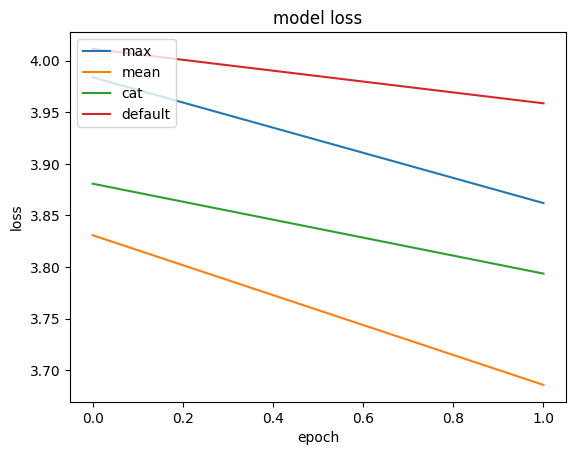

In [16]:
plot_models(histories, patterns, 'loss')

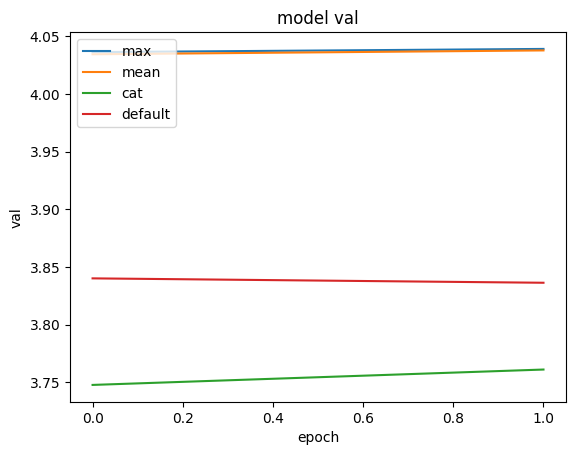

In [17]:
plot_models(histories, patterns, 'val')

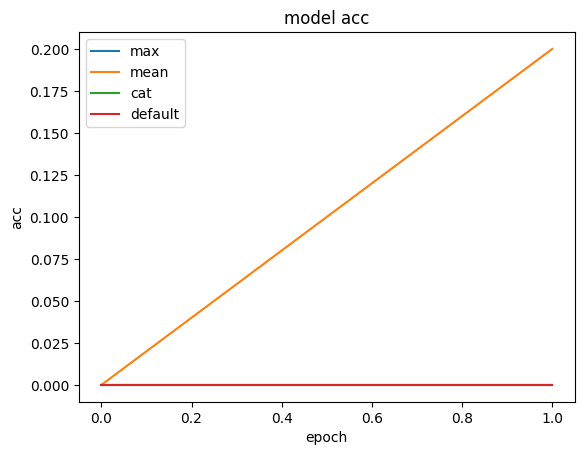

In [18]:
plot_models(histories, patterns, 'acc')

## 7. Testing Metrics

In [19]:
def testing_metrics(tests, patterns, export=True):
    stats = {}
    for model_test, pattern in zip(tests,patterns):
        y_true, y_pred, y_proba = model_test
        scores = metrics.classification_report(y_true, y_pred, zero_division=1, output_dict=True)

        stats[pattern] = {
            'cohen_kappa': metrics.cohen_kappa_score(y_true, y_pred),
            'matthews_corrcoef': metrics.matthews_corrcoef(y_true, y_pred),
            'log_loss': metrics.log_loss(y_true, y_proba, labels=np.arange(NUM_CLASSES)),
    #         'roc_auc': metrics.roc_auc_score(y_true, y_proba, average='weighted', labels=np.arange(NUM_CLASSES), multi_class='ovr'),
            'micro-accuracy': scores['accuracy']
        }

        for metr1 in ('macro avg', 'weighted avg'):
            for metr2 in ('precision', 'recall', 'f1-score'):
                stats[pattern][metr1 + ' ' + metr2] = scores[metr1][metr2]
    
    stats_df = pd.DataFrame.from_dict(stats).T
    if export:
        stats_df.to_csv('transformer_stats.csv')
    
    return stats_df

In [20]:
testing_metrics(tests, patterns)

,cohen_kappa,matthews_corrcoef,log_loss,micro-accuracy,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score
max,0.0,0.0,23.212092,0.0,0.555556,0.444444,0.0,1.0,0.0,0.0
mean,0.0,0.0,17.058557,0.0,0.714286,0.285714,0.0,1.0,0.0,0.0
cat,0.0,0.0,23.060824,0.0,0.714286,0.285714,0.0,1.0,0.0,0.0
default,0.0,0.0,23.517410,0.0,0.714286,0.285714,0.0,1.0,0.0,0.0
